In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Download the codeSearchNetChallenge dataset 
_If needed_

In [2]:
%run downloading_cleaning_codeSearchNetChallenge_dataset.ipynb

CodeSearchNet challenge dataset ready to use!


## Exporting the codeSearchNetChallenge dataset to CSV files

_If needed_

In [3]:
%run preparing_csv_files_from_codeSearchNetChallenge_dataset.ipynb

Total lines of Python code in the dataset (after removing empty lines)
11206193


Total lines of Python code in the dataset's train folder (after removing empty lines)
10054266


Total lines of Python in the dataset's test folder (after removing empty lines)
541338


Total lines of Python in the dataset's valid folder
610589


## Training tokenizer using SentencePiece

_model_type=unigram_

In [4]:
import torch
print ('Current cuda device in use: ', torch.cuda.current_device())

Current cuda device in use:  0


In [5]:
from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece

In [6]:
from tokenizer_utils import CustomTokenizer, SPTokenizer

In [7]:
vocab_size = 600
model_prefix = 'unigram_model'

In [8]:
codeSearchNet_challenge_path = './CodeSearchNet_challenge_dataset'
all_csv_path = './CodeSearchNet_challenge_dataset/CodeSearchNet_challenge_dataset.csv'
train_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/train/train_CodeSearchNet_challenge_dataset.csv'
test_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/test/test_CodeSearchNet_challenge_dataset.csv'
valid_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/valid/valid_CodeSearchNet_challenge_dataset.csv'

In [9]:
spm.SentencePieceTrainer.Train(f'--input={all_csv_path}'\
                               f' --model_prefix={model_prefix}'\
                               f' --vocab_size={vocab_size}'\
                               f' --model_type=unigram'\
                               f' --unk_piece={UNK} --bos_piece={BOS} --eos_id=-1 --pad_piece={PAD}')

In [10]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [11]:
itos = []
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

In [12]:
mycust_tok = CustomTokenizer(SPTokenizer, model_prefix)

In [13]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

In [14]:
data = TextLMDataBunch.from_csv('./', train_csv_path, test=test_csv_path, tokenizer=mycust_tok, vocab=sp_vocab)

/opt/tljh/user/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [15]:
data.save('20200811_unigram_model_databunch_data_save.pkl') 

In [16]:
data.show_batch()

/opt/tljh/user/lib/python3.7/site-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,". ▁The re ▁is ▁ s u all y ▁no ▁need ▁to ▁call ▁this ▁ dir ect ly , ▁in v o k ed ▁ im pl ic it ly ▁by ▁ : me th : ` co py ` "" "" "" ▁if ▁self . id : ▁self . id ▁+= ▁ id s u ff ix ▁if ▁re cur s ive : ▁for ▁ e ▁in ▁self :"
1,"t ): ▁"""" "" ▁ T r ies ▁ find ing ▁m et a data ▁ th ro u g h ▁S p ot if y ▁"""" "" ▁ s on g _ name ▁= ▁ im p ro v e _ name ( file _ name ) ▁# ▁ Re m o v e ▁use le s s ▁ word s ▁from ▁ title ▁ client _ c re"
2,"L _ N A M E } "" ) ▁return ▁ ut il s . re tr i e v e _ and _ parse _ p ro file ( id ) ▁def ▁ handle _ re ce ive ( ▁ request : ▁ Re qu est Type , ▁ user : ▁ U s er Type ▁= ▁None , ▁ s end er _ key _ f et ch"
3,"out s ): ▁"""" "" ▁ O ver r id e s ▁the ▁ filter s ▁specified ▁in ▁the ▁de c or ator ▁with ▁the ▁given ▁ one s ▁ : param ▁ config s : ▁ F i el d ▁ xxunk ▁ ( Re qu i re ment , ▁key , ▁all ow _ n one ) ▁ dict ion ary ▁ : param ▁ require s _"
4,", ▁ default ▁ False ▁ loc ation ▁ : ▁str ▁ loc ation ▁name , ▁ default ▁ "" un k n ow n "" ▁ lat ▁ : ▁ float ▁ lat it u de , ▁ default ▁"""" ▁ l on ▁ : ▁ float ▁ l on g it u de , ▁ default ▁"""" ▁d m y _ flag ▁ : ▁ bool ▁ default"


In [18]:
torch.cuda.set_device(1)
print ('Current cuda device in use: ', torch.cuda.current_device())

Current cuda device in use:  1


In [19]:
data = load_data('./', '20200811_unigram_model_databunch_data_save.pkl', bs=1600)

In [20]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [21]:
print(learn.model)

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(600, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(600, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=600, bias=True)
    (output_dp): RNNDropout()
  )
)


In [22]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 600]            240,600    True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 240,600
Total trainable params: 240,600
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.32E-01


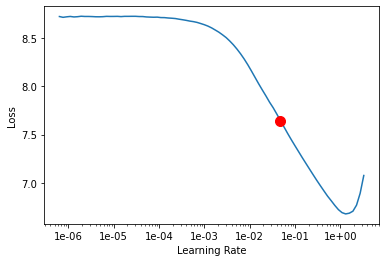

In [25]:
learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(1, slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.293419,3.128795,0.323507,19:57


In [27]:
learn.save('20200811_fit_head_unigram_model_drop_mult')

In [28]:
learn.load('20200811_fit_head_unigram_model_drop_mult');

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(30, slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.919357,2.005627,0.521201,29:02
1,1.816470,1.948524,0.530950,29:05
2,1.837683,1.980030,0.525545,29:06
3,1.890795,2.026043,0.517280,29:10
4,1.918389,2.055678,0.513233,29:06
5,1.931627,2.073259,0.510880,29:01
6,1.935717,2.096344,0.507261,28:50
7,1.930167,2.066913,0.511508,28:42
8,1.895413,2.056256,0.513242,28:43
9,1.878500,2.040625,0.516288,28:43


In [31]:
# learn.save('fine_tuned')
learn.save('20200811_fine_tuned_unigram_model_drop_mult')

In [32]:
# learn.load('fine_tuned');
learn.load('20200811_fine_tuned_unigram_model_drop_mult');

In [33]:
TEXT = "import from"
N_WORDS = 25
N_SENTENCES = 3
for _ in range(N_SENTENCES):
    predicted = learn.predict(TEXT, N_WORDS, temperature=0.9)
    val = predicted.replace(TEXT, '')
    decoded = sp.decode_pieces(val.split())
    print(TEXT + " "+  decoded)

import from _xml(xml_file) if needs_global: model = E
import from postschemata of 3D** cursor.move_to(
import from integers As following # ( \ u1284) in


In [34]:
print(learn.summary())

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 600]            240,600    True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 240,600
Total trainable params: 240,600
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function

In [35]:
TEXT = "from pandas import"
N_WORDS = 25
N_SENTENCES = 5
for _ in range(N_SENTENCES):
    predicted = learn.predict(TEXT, N_WORDS, temperature=0.9)
    val = predicted.replace(TEXT, '')
    decoded = sp.decode_pieces(val.split())
    print(TEXT + " "+  decoded)

from pandas import xarray, xems, results, output=msbov_mcmch
from pandas import XmlDataset X60 = X64Preference(Xnew,
from pandas import Factory for nums in np.array(possible_inserts
from pandas import LinearOptions Returns Objective object type when doing 
from pandas import dict(itertools.chain(*vals)) idx = idx()
